In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
from pylab import rcParams
import matplotlib.pyplot as plt
import pathlib
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
from datasets import load_dataset

c:\Users\DeboraOrsolich\miniconda3\envs\ques_gen_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### BASIC DATASET EXPLORATION

In [2]:
dataset = load_dataset('squad_v2', split="train")
validation = load_dataset('squad_v2', split="validation")

print(f"There are {len(dataset)} contexts-questions pairs in train set")
print(f"There are {len(validation)} contexts-questions pairs in validation set")
print()

contexts_train = [example["context"] for example in dataset]
contexts_val = [example["context"] for example in validation]
print(f"There are {len(set(contexts_train))} unique contexts in train set")
print(f"There are {len(set(contexts_val))} unique contexts in val set")
print()

titles_train = [example["title"] for example in dataset]
titles_val = [example["title"] for example in validation]
print(f"There are {len(set(titles_train))} unique titles in train set")
print(f"There are {len(set(titles_val))} unique titles in val set")

Reusing dataset squad_v2 (C:\Users\DeboraOrsolich\.cache\huggingface\datasets\squad_v2\squad_v2\2.0.0\09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)
Reusing dataset squad_v2 (C:\Users\DeboraOrsolich\.cache\huggingface\datasets\squad_v2\squad_v2\2.0.0\09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


There are 130319 contexts-questions pairs in train set
There are 11873 contexts-questions pairs in validation set

There are 19029 unique contexts in train set
There are 1204 unique contexts in val set

There are 442 unique titles in train set
There are 35 unique titles in val set


In [3]:
from collections import Counter
import numpy as np

def sort_topics(titles_split):
    ini_list = titles_split

    # sorting on bais of frequency of elements
    topics_sorted = [item for items, c in Counter(ini_list).most_common() for item in [items] * c]
    unique_ordered = []
    for title in topics_sorted:
        if title not in unique_ordered:
            unique_ordered.append(title)
    return topics_sorted, unique_ordered

def count(topics_sorted, unique_ordered, x, top=10):
    counts = []
    print(f"Top {top} {x} and number of questions in each {x}")
    for i, title in enumerate(unique_ordered):
        counts.append(topics_sorted.count(title))
        if i < top:
            print(f"{f'{x}':<7}{'{}'.format(title):<45}{'Count':<10}{'{}'.format(topics_sorted.count(title)):<12}")
    return counts 

In [4]:
print("Train set")
topics_sorted_train, unique_ordered_train = sort_topics(titles_train)
counts_train = count(topics_sorted_train, unique_ordered_train, x="topics")

print()
print("Validation set")
topics_sorted_val, unique_ordered_val = sort_topics(titles_val)
counts_val = count(topics_sorted_val, unique_ordered_val, x="topics")

Train set
Top 10 topics and number of questions in each topics
topics Queen_Victoria                               Count     883         
topics New_York_City                                Count     817         
topics American_Idol                                Count     790         
topics Beyoncé                                      Count     753         
topics Frédéric_Chopin                              Count     697         
topics Buddhism                                     Count     610         
topics Pharmaceutical_industry                      Count     586         
topics New_Haven,_Connecticut                       Count     582         
topics Premier_League                               Count     551         
topics Hunting                                      Count     531         

Validation set
Top 10 topics and number of questions in each topics
topics Economic_inequality                          Count     515         
topics Rhine                               

In [5]:
print("Train set")
contexts_sorted_train, contexts_unique_ordered_train = sort_topics(contexts_train)
contexts_counts_train = count(contexts_sorted_train, contexts_unique_ordered_train, x="contexts", top=1)

print()
print("Validation set")
contexts_sorted_val, contexts_unique_ordered_val = sort_topics(contexts_val)
contexts_counts_val = count(contexts_sorted_val, contexts_unique_ordered_val, x="contexts", top=1)

Train set
Top 1 contexts and number of questions in each contexts
contextsVictoria married her first cousin, Prince Albert of Saxe-Coburg and Gotha, in 1840. Their nine children married into royal and noble families across the continent, tying them together and earning her the sobriquet "the grandmother of Europe". After Albert's death in 1861, Victoria plunged into deep mourning and avoided public appearances. As a result of her seclusion, republicanism temporarily gained strength, but in the latter half of her reign her popularity recovered. Her Golden and Diamond Jubilees were times of public celebration.Count     30          

Validation set
Top 1 contexts and number of questions in each contexts
contextsBaran developed the concept of distributed adaptive message block switching during his research at the RAND Corporation for the US Air Force into survivable communications networks, first presented to the Air Force in the summer of 1961 as briefing B-265, later published as RAND re

In [6]:
print(f"Train: Average of {np.mean(contexts_counts_train)} questions per context")
print(f"Validation: Average of {np.mean(contexts_counts_val)} questions per context")

Train: Average of 6.848441851910242 questions per context
Validation: Average of 9.861295681063122 questions per context


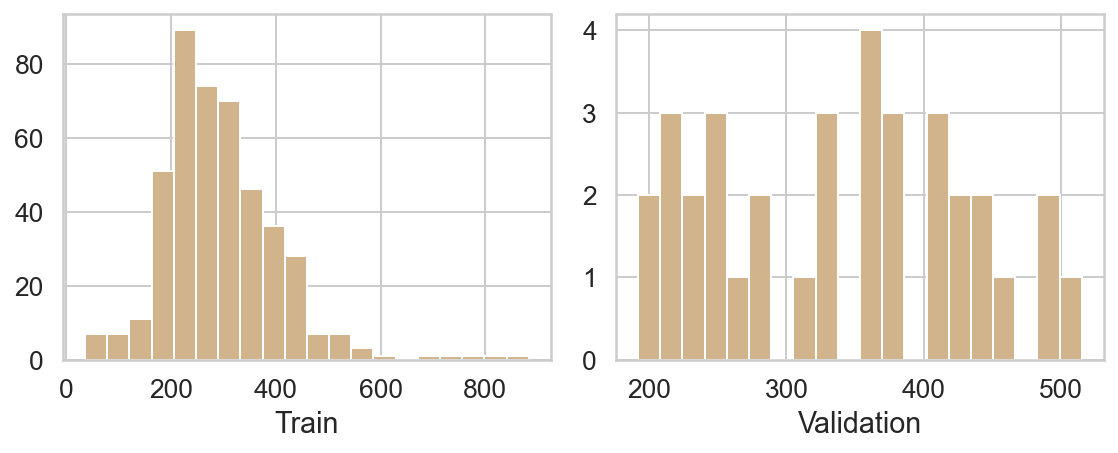

In [7]:
# Create figure
fig = plt.figure(figsize=(8,6))

plt.subplot(2, 2, 1)
plt.hist(counts_train, bins=20, color='tan')
plt.xlabel('Train')
plt.subplot(2, 2, 2)
plt.hist(counts_val, bins=20, color='tan')
plt.xlabel('Validation')
plt.tight_layout()
plt.show()

### CONCEPTS DETECTION WITH PART-OF-SPEACH TAGGING ANALYSIS

In [8]:
import pathlib
import spacy
import os
import json
from tqdm import tqdm
try:
    nlp = spacy.load("en_core_web_lg")
except:
    os.system("python -m spacy download en_core_web_lg")
    nlp = spacy.load("en_core_web_lg")
list_stopwords = nlp.Defaults.stop_words

In [9]:
class POS_analysis:
    def __init__(self) -> None:
        
        self.concepts_lemma = []
        self.concepts_string = []
        self.tracking_index = []

    def nlp_pipeline(self, texts):
        return list(nlp.pipe(texts))

    def extract_pos_concepts(self, nlp_sentence, filter_pos:list = ["NOUN", "ADJ", "PROPN"], split_in_documents = False):
        """
        """
        self.filter_pos = filter_pos

        if split_in_documents:
            self.concepts_lemma = []
            self.concepts_string = []
            self.tracking_index = []

        for token in nlp_sentence:
            
            if (token.is_alpha and not token.is_stop and
                token.pos_ in self.filter_pos and
                token.text not in ["dsfdsfdsqfsqdfdsqf"]):

                ## the following if statement manage to match words that belong to the same concept. 
                ## e.g: ["software", "development"] -> "software development"

                # only for the first concept
                if self.tracking_index == []:
                    self.concepts_lemma.append([token.lemma_])
                    self.concepts_string.append([token.text])
                    self.tracking_index.append([token.i])

                # checking if the word (NOUN or ADJ) matches with the previous word (NOUN or ADJ)
                elif self.tracking_index[-1][-1] == token.i-1:
                    # managing concept lemma
                    self.concepts_lemma[-1].append(token.lemma_)
                    updated_concept_lemma = (" ").join(self.concepts_lemma[-1])
                    self.concepts_lemma[-1] = [updated_concept_lemma]

                    # managing concept string
                    self.concepts_string[-1].append(token.text)
                    updated_concept_string = (" ").join(self.concepts_string[-1])
                    self.concepts_string[-1] = [updated_concept_string]

                    # managing concept position in the context (index)
                    self.tracking_index[-1].append(token.i)

                else: # initializing new concept
                    self.concepts_lemma.append([token.lemma_])
                    self.concepts_string.append([token.text])
                    self.tracking_index.append([token.i])

                if token.lemma_ == "dsfdsfdsqfsqdfdsqf":
                    print(token, token.lemma_)

        self.all_concepts_string = [concept[0] for concept in self.concepts_string]
        self.all_concepts_lemma = [concept[0] for concept in self.concepts_lemma]

        return self


In [10]:
def list_all_tokens(list_of_lists):
    all_tokens = []
    for question in list_of_lists:
        for token in question:
            all_tokens.append(token)
    return all_tokens

In [20]:
ROOT_DIR = pathlib.Path().resolve().parents[1]
print(f"Root directory: {ROOT_DIR}")
DATA_DIR_AA = ROOT_DIR/'qg'/'transformers_models'/'t5small_batch32_AA'
DATA_DIR_AQPL = ROOT_DIR/'qg'/'transformers_models'/'t5small_batch32_AQPL'
DATA_DIR_BASIC = ROOT_DIR/'qg'/'transformers_models'/'t5small_batch32_basic'
DATA_DIR_OQPL = ROOT_DIR/'qg'/'transformers_models'/'t5small_batch32_OQPL'



Root directory: C:\Users\DeboraOrsolich\Development\question_generation_models\deep_qg


In [27]:

results_folders = ["AA", "AQPL", "basic", "OQPL"]
splits = ["train", "validation"]
results = {}
for split in splits:
    for folder in results_folders:
        # Uploading generated questions...
        with open(ROOT_DIR/f"qg/transformers_models/t5small_batch32_{folder}/mapped_{split}_questions.json", encoding="utf-8") as f:
            questions = json.load(f)
            predictions = questions["predictions"]
            references = questions["references"]

            sets = [predictions, references]
            sets_names = ["predictions", "references"]

            for s_i,(set, name) in enumerate(zip(sets, sets_names)):
                print(f"Extracting concepts from {name} {folder}...")
                pos_analysis = POS_analysis()
                
                questions_pipeline = pos_analysis.nlp_pipeline(set)
                print(f"Pipeline generated...")

                strings = []
                lemmas = []

                for question in tqdm(questions_pipeline):
                    pos_analysis.extract_pos_concepts(question, split_in_documents=True)
                    strings.append(pos_analysis.all_concepts_string)
                    lemmas.append(pos_analysis.all_concepts_lemma)

                # splitted_strings = pos_analysis.all_concepts_string
                # splitted_lemmas = pos_analysis.all_concepts_lemma
                concepts = {}
                concepts["strings"] = strings
                concepts["lemmas"]  = lemmas
                results[f"{folder}_{split}_{name}"] = concepts
with open ("concepts_ref_gen_questions.json","w+", encoding='utf-8') as f:
    json.dump(results,f)


Extracting concepts from predictions AA...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 30829.47it/s]


Extracting concepts from references AA...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 41461.68it/s]


Extracting concepts from predictions AQPL...
Pipeline generated...


100%|██████████| 21890/21890 [00:00<00:00, 35828.65it/s]


Extracting concepts from references AQPL...
Pipeline generated...


100%|██████████| 21890/21890 [00:00<00:00, 39871.75it/s]


Extracting concepts from predictions basic...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 73864.98it/s]


Extracting concepts from references basic...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 73856.62it/s]


Extracting concepts from predictions OQPL...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 64058.49it/s]


Extracting concepts from references OQPL...
Pipeline generated...


100%|██████████| 18836/18836 [00:00<00:00, 71595.17it/s]


Extracting concepts from predictions AA...
Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 73562.35it/s]

Extracting concepts from references AA...


Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 65346.02it/s]

Extracting concepts from predictions AQPL...


Pipeline generated...


100%|██████████| 1350/1350 [00:00<00:00, 67462.27it/s]

Extracting concepts from references AQPL...


Pipeline generated...


100%|██████████| 1350/1350 [00:00<00:00, 64207.99it/s]

Extracting concepts from predictions basic...


Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 62078.84it/s]

Extracting concepts from references basic...


Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 73553.58it/s]

Extracting concepts from predictions OQPL...


Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 58901.31it/s]

Extracting concepts from references OQPL...


Pipeline generated...


100%|██████████| 1177/1177 [00:00<00:00, 65269.13it/s]


In [29]:
results.keys()

dict_keys(['AA_train_predictions', 'AA_train_references', 'AQPL_train_predictions', 'AQPL_train_references', 'basic_train_predictions', 'basic_train_references', 'OQPL_train_predictions', 'OQPL_train_references', 'AA_validation_predictions', 'AA_validation_references', 'AQPL_validation_predictions', 'AQPL_validation_references', 'basic_validation_predictions', 'basic_validation_references', 'OQPL_validation_predictions', 'OQPL_validation_references'])

In [30]:
results["AA_train_predictions"]

{'strings': [['Beyonce', 'album'],
  ['Beyoncé', 'fifth album'],
  ['Grammy Awards', 'Beyoncé'],
  ['Beyonce Giselle Knowles'],
  ['Beyonce', 'Mary', 'Elementary School'],
  ['Beyonce', 'father', 'job', 'group'],
  ['Destiny', 'Child', 'major label debut song', 'Time'],
  ['Farrah Franklin', 'Michelle Williams'],
  ['Destiny', 'Child', 'album'],
  ['year', 'Beyonce star', 'Cuba Gooding'],
  ['awards', 'Beyonce', 'Grammy Awards'],
  ['Beyonce', 'American national anthem', 'Super Bowl XXXVIII'],
  ['copies', 'Beyonce', 'second solo album', 'week'],
  ['Beyonce', 'worldwide concert tour'],
  ['Beyonce', 'second', 'worldwide tour'],
  ['movie', 'Beyoncé'],
  ['nominations', 'Beyonce', 'Annual Grammy Awards'],
  ['Beyonce', 'hiatus', 'music career'],
  ['highest', 'performer', 'world', 'minute'],
  ['copies', 'Beyonce', 'fourth album', 'week'],
  ['Beyonce', 'birth', 'child'],
  ['Destiny', 'Child release Love Songs'],
  ['successful tour', 'Beyonce', 'career'],
  ['Beyonce', 'fifth album']

In [32]:
results["AA_train_references"]

{'strings': [['Beyoncé', 'solo album'],
  ['Beyoncé', 'second solo album'],
  ['Grammy awards', 'Beyoncé'],
  ['Beyoncé', 'mother', 'Beyoncé', 'child'],
  ['type', 'school', 'Parker Elementary School'],
  ['year', 'Beyonce', 'father', 'job', 'group'],
  ['Destiny', 'Child', 'second album'],
  ['Luckett', 'Roberson', 'Destiny', 'Child'],
  ['Destiny Child', 'album'],
  ['genre', 'movie', 'Beyonce star', 'Cuba Gooding', 'Jr'],
  ['awards', 'Beyoncé', 'Grammy', 'Awards'],
  ['year', 'Beyonce', 'Love tour', 'Europe'],
  ['albums', 'Beyonce', 'week', 'second album'],
  ['Beyonce', 'concert tour'],
  ['Beyonce', 'second world tour'],
  ['thriller film', 'Beyonce star'],
  ['Beyonce', 'nominations', 'Annual Grammy Awards'],
  ['year', 'Beyonce', 'hiatus'],
  ['Beyonce', 'performer'],
  ['copies', 'album', 'week'],
  ['Beyonce', 'birth', 'child'],
  ['Destiny', 'Child release Love Songs'],
  ['Beyonce', 'successful tours'],
  ['Beyonce', 'album', 'huge surprise'],
  ['Beyonce', 'artist', 'Albu